Nama: Caroline Ang \
NIM: 2702208606

Dataset:\
Booking_ID                          : ID Unique untuk setiap pesanan\
no_of_adults                        : Jumlah adult/orang dewasa\
no_of_children                      : Jumlah anak kecil\
no_of_weekend_nights                : Jumlah hari menginap pada akhir pekan (sabtu-minggu)\
no_of_week_nights                   : Jumlah hari menginap pada hari biasa (senin-jumat)\
type_of_meal_plan                   : Pilihan paket makanan tamu\
required_car_parking_space          : Apakah perlu tempat parkir mobil (0-No, 1-Yes)\
room_type_reserved                  : Jenis kamar yang dipesan (encrypted oleh INN Hotels)\
lead_time                           : Jarak hari pemesanan kamar dan tanggal menginap \
arrival_year                        : Tahun menginap\
arrival_month                       : Bulan menginap\
arrival_date                        : Tanggal menginap\
market_segment_type                 : Penunjukkan segmen pasar\
repeated_guest                      : Apakah tamu yang pernah memesan dan menginap sebelumnya (0-No, 1-Yes)\
no_of_previous_cancellations        : Jumlah pemesanan yang pernah dibatalkan oleh tamu\
no_of_previous_bookings_not_canceled: Jumlah pemesanan yang tidak dibatalkan oleh tamu\
avg_price_per_room                  : Harga rata-rata per hari (bersifat dinamis + dalam euro)\
no_of_special_requests              : Jumlah permintaan khusus yang dibuat oleh tamu

Target:\
booking_status                      : Penanda untuk menunjukkan apakah pesanan dibatalkan atau tidak

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import statistics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

## A. Preprocessing

### Reading Dataset

In [4]:
df = pd.read_csv('Dataset_B_hotel.csv')
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Membuka file dataset dan menjadikannya sebagai dataframe

### Checking number of NULL, Data Type, and Duplicates

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Terdapat 4 kolom yang merupakan object, yaitu type_of_meal_plan, room_type_reserved, market_segment_type, dan booking_status (target variable). Nanti akan dilakukan encode untuk kolom yang berisi data kategorikal ini.

In [6]:
df.isna().sum()

Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        907
required_car_parking_space              1270
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1632
no_of_special_requests                     0
booking_status                             0
dtype: int64

Terdapat NULL pada data type_of_meal_plan, required_car_parking_space, dan avg_price_per_room.\
Untuk data numerikal, jika data tersebar secara normal akan digunakan mean, tetapi jika terdapat outlier akan menggunakan median. Hal tersebut akan ditentukan melalui boxplot nanti.

Untuk data kategorikal, akan digunakan modus.

In [7]:
print(df.duplicated().sum())
df[df.duplicated()]

0


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


Tidak ada data duplikat pada dataset ini

### Checking the categorical data value counts

In [8]:
categorical = []
numerical = []

for i in df.columns:
  if (df[i].dtype == 'object'):
    categorical.append(i)
  else:
    numerical.append(i)

Loop untuk memisahkan kolom yang berupa object/data kategorikal dengan kolom yang merupakan data numerical

In [9]:
for i in categorical:
  if (i == 'Booking_ID'): continue
  print(df[i].value_counts())
  print()

type_of_meal_plan
Meal Plan 1     27157
Not Selected     4986
Meal Plan 2      3220
Meal Plan 3         5
Name: count, dtype: int64

room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64



Melakukan pengecekan untuk jumlah value/data yang ada pada kolom kategorikal, kecuali Booking_ID yang bersifat unique dan tidak digunakan untuk model machine learning nantinya.

### Describing the numerical dataset

In [10]:
df[numerical].describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,35005.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,34643.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.031281,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.447208,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.174079,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.158417,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.275000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Dari tabel diatas, tidak terlihat anomali (misalkan jumlah anak -2, tetapi hal tersebut tidak mungkin)

### Making input and output Data

In [11]:
x = df.drop(columns=['Booking_ID', 'booking_status'], axis=1)
y = df['booking_status']

In [12]:
x.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0
1,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1
2,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0
3,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0
4,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0


In [13]:
y.head()

0    Not_Canceled
1    Not_Canceled
2        Canceled
3        Canceled
4        Canceled
Name: booking_status, dtype: object

Bagian ini memisahkan dataframe menjadi 2, yaitu x yang akan menjadi input dan y yang menjadi output. 

Booking_ID tidak akan digunakan dalam model machine learning ini karena hanya berupa penanda/index yang membedakan order setiap tamu, tetapi tidak memiliki dampak apapun kepada model machine learning ini

### Splitting data into Train and Test

In [14]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 42)
xTrain.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
25629,2,1,2,1,Meal Plan 1,0.0,Room_Type 1,26,2017,10,17,Online,0,0,0,161.00,0
14473,2,1,1,1,Meal Plan 1,0.0,Room_Type 1,98,2018,7,16,Online,0,0,0,121.50,2
23720,2,0,0,3,Meal Plan 1,0.0,Room_Type 1,433,2018,9,8,Offline,0,0,0,70.00,0
5843,2,0,2,5,Meal Plan 1,0.0,Room_Type 1,195,2018,8,8,Offline,0,0,0,72.25,0
18709,1,0,0,2,Meal Plan 1,0.0,Room_Type 1,188,2018,6,15,Offline,0,0,0,130.00,0


Menggunakan function train_test_split, data x dan y akan dipisah menjadi 80% train dan 20% test. random_state digunakan untuk memastikan saat model di run ulang, hasil split yang didapatkan itu sama.

### Filling Null data

#### Numerical data

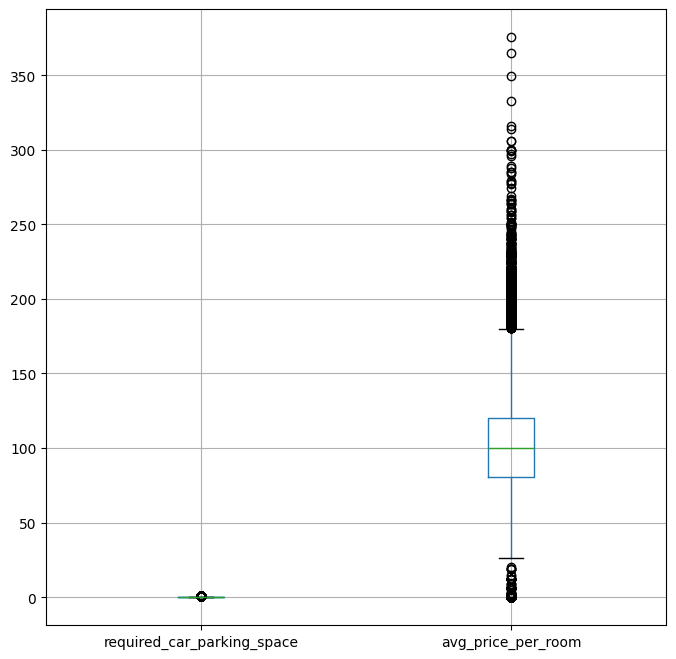

In [15]:
plt.figure(figsize=(8, 8))
xTrain.boxplot(column=['required_car_parking_space', 'avg_price_per_room'])
plt.show()

dari boxplot untuk kedua data numerikal yang memiliki NULL (required_car_parking_space dan avg_price_per_room), dapat dilihat terdapat banyak outlier untuk keduanya, hal ini ditandai dengan keberadaan lingkaran hitam pada plot yang berjumlah banyak. Oleh karena itu, saya akan menggunakan median untuk fill NULL tersebut

In [16]:
carParking = np.median(xTrain['required_car_parking_space'])
avgPrice = np.median(xTrain['avg_price_per_room'])

print(carParking)
print(avgPrice)

nan
nan


Dari hasil perhitungan diatas, dapat dilihat ternyata median untuk kedua data adalah nan, sehingga data xTrain akan dimodifikasi

In [17]:
carParking = np.median(xTrain['required_car_parking_space'].dropna())
avgPrice = np.median(xTrain['avg_price_per_room'].dropna())

print(carParking)
print(avgPrice)

0.0
99.9


Agar dapat mendapatkan hasil median dari data xTrain, dropna harus di-apply terhadap xTrain agar tidak mendapatkan hasil nan lagi. Lalu didapatlah nilai median, yaitu 0 untuk required_car_parking_space dan 99.9 untuk avg_price_per_room.

#### Kategorikal

In [18]:
mealPlan = statistics.mode(xTrain['type_of_meal_plan'])
mealPlan

'Meal Plan 1'

Dengan menggunakan function statistics.mode, diperoleh hasil modus untuk kolom type_of_meal_plan, yaitu Meal Plan 1

In [19]:
xTrain['required_car_parking_space'] = xTrain['required_car_parking_space'].fillna(0)
xTrain['avg_price_per_room'] = xTrain['avg_price_per_room'].fillna(99.9)
xTrain['type_of_meal_plan'] = xTrain['type_of_meal_plan'].fillna('Meal Plan 1')

xTest['required_car_parking_space'] = xTest['required_car_parking_space'].fillna(0)
xTest['avg_price_per_room'] = xTest['avg_price_per_room'].fillna(99.9)
xTest['type_of_meal_plan'] = xTest['type_of_meal_plan'].fillna('Meal Plan 1')

Setelah mendapatkan hasil median dan modus untuk setiap kolom, kedua data xTrain dan xTest di-impute sesuai dengan data yang telah kita terima

In [20]:
xTrain.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

In [21]:
xTest.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

Disini saya memastikan kembali setiap row pada xTrain dan xTest sudah terimpute dan tidak memiliki data NULL lagi. 

### Encoding

#### Encoding y (output) values

Kedua model yang tertera, yaitu RandomForestClassifier dan XGBClassifier membutuhkan input dan output yang berupa numerical. Oleh karena itu, output yang ada pada dataset ini (yTrain dan yTest) juga harus di encode.

In [22]:
print(np.unique(yTrain))
print(np.unique(yTest))

['Canceled' 'Not_Canceled']
['Canceled' 'Not_Canceled']


Dapat dilihat, kedua yTrain dan yTest memiliki value yang sama yaitu 'Canceled' dan 'Not_Canceled'. Karena output hanya ada 2, maka soal ini merupakan Binary Classification dan LabelEncoder akan digunakan untuk membuat data menjadi binary (0/1)

In [23]:
bookingStatsEncoder = LabelEncoder()

yTrain = bookingStatsEncoder.fit_transform(yTrain)
yTest = bookingStatsEncoder.transform(yTest)

In [24]:
print(np.unique(yTrain))
print(np.unique(yTest))

[0 1]
[0 1]


Seteleh encoding, yTrain dan yTest menjadi 0 dan 1, bukan 'Canceled' dan 'Not_Canceled', sehingga data yTrain dan yTest sudah bisa digunakan untuk machine learning.

#### Encoding x (input) values

In [25]:
mealPlanEncTrain = xTrain[['type_of_meal_plan']]
roomTypeEncTrain = xTrain[['room_type_reserved']]
marketSegmentEncTrain = xTrain[['market_segment_type']]

mealPlanEncTest = xTest[['type_of_meal_plan']]
roomTypeEncTest = xTest[['room_type_reserved']]
marketSegmentEncTest = xTest[['market_segment_type']]

mealPlanEncoder = OneHotEncoder()
roomTypeEncoder = OneHotEncoder()
marketSegmentEncoder = OneHotEncoder()

Seperti yang terdapat pada bagian value_counts, karena type_of_meal_plan, room_type_reserved, dan market_segment_type memiliki beberapa value, maka OneHotEncoder akan digunakan untuk meng-encode categorical value tersebut.

In [ ]:
mealPlanEncTrain = pd.DataFrame(mealPlanEncoder.fit_transform(mealPlanEncTrain).toarray(), columns=mealPlanEncoder.get_feature_names_out())
roomTypeEncTrain = pd.DataFrame(roomTypeEncoder.fit_transform(roomTypeEncTrain).toarray(), columns=roomTypeEncoder.get_feature_names_out())
marketSegmentEncTrain = pd.DataFrame(marketSegmentEncoder.fit_transform(marketSegmentEncTrain).toarray(), columns=marketSegmentEncoder.get_feature_names_out())

mealPlanEncTest = pd.DataFrame(mealPlanEncoder.transform(mealPlanEncTest).toarray(), columns=mealPlanEncoder.get_feature_names_out())
roomTypeEncTest = pd.DataFrame(roomTypeEncoder.transform(roomTypeEncTest).toarray(), columns=roomTypeEncoder.get_feature_names_out())
marketSegmentEncTest = pd.DataFrame(marketSegmentEncoder.transform(marketSegmentEncTest).toarray(), columns=marketSegmentEncoder.get_feature_names_out())

Membuat dataframe untuk setiap kolom kategorikal yang diencode untuk di concatenate dengan dataframe xTrain dan xTest nantinya.

toarray() digunakan karena output dari fit_transform dan transform OneHotEncoder berupa csr_matrix, sehingga harus di ganti tipenya dengan bantuan function to array sebelum dapat dibuat menjadi dataframe

In [27]:
xTrain = xTrain.reset_index()
xTest = xTest.reset_index()

xTrain = pd.concat([xTrain, mealPlanEncTrain, roomTypeEncTrain, marketSegmentEncTrain], axis=1)
xTest = pd.concat([xTest, mealPlanEncTest, roomTypeEncTest, marketSegmentEncTest], axis=1)

reset_index digunakan untuk mereset index xTrain dan xTest, karena saat splitting data, index kemungkinan akan teracak, sehingga reset_index akan membuat index data kembali dari 0 hingga jumlah data. 

Concatenate akan dilakukan sesuai dengan index yang ada. Misalkan tidak reset_index, bisa jadi data tergabung pada row yang salah dan dapat mengakibatkan munculnya NULL dalam dataset karena index yang tidak match tersebut.

In [28]:
print(xTrain.isna().sum())

print()

print(xTest.isna().sum())

index                                   0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
type_of_meal_plan_Meal Plan 1           0
type_of_meal_plan_Meal Plan 2           0
type_of_meal_plan_Meal Plan 3           0
type_of_meal_plan_Not Selected          0
room_type_reserved_Room_Type 1          0
room_type_reserved_Room_Type 2    

Encoding telah berhasil dilakukan dan tidak terdapat NULL pada dataset setelah concat dilakukan

In [29]:
binaryEncoder = {'required_car_parking_space' : {
        'Yes' : 1, 
        'No' : 0
    }, 
    'repeated_guest' : {
        'Yes' : 1, 
        'No' : 0
    }
}

xTrain = xTrain.replace(binaryEncoder)
xTest = xTest.replace(binaryEncoder)

Encoder diatas merupakan encoder manual, jika terdapat input yang bukan merupakan 1/0, tetapi Yes/No untuk kolom required_car_parking_space dan repeated_guest

### Saving encoder as pickle

In [30]:
bookingStatsFileName = 'bookingStatsEncode.pkl'
mealPlanFileName = 'mealPlanEncode.pkl'
roomTypeFileName = 'roomTypeEncode.pkl'
marketSegmentFileName = 'marketSegmentEncode.pkl'
binaryEncFileName = 'binaryEncode.pkl'

pkl.dump(bookingStatsEncoder, open(bookingStatsFileName, 'wb'))
pkl.dump(mealPlanEncoder, open(mealPlanFileName, 'wb'))
pkl.dump(roomTypeEncoder, open(roomTypeFileName, 'wb'))
pkl.dump(marketSegmentEncoder, open(marketSegmentFileName, 'wb'))
pkl.dump(binaryEncoder, open(binaryEncFileName, 'wb'))


Encoder yang digunakan dalam machine learning ini, akan disimpan sebagai pickle agar dapat digunakan tanpa harus mengencode kembali. 

## B. Model Learning and Training

### Data Preparation

In [31]:
yCheck = bookingStatsEncoder.inverse_transform(yTest)

yCheck akan digunakan untuk classification_report nantinya, karena data telah di transform, maka hasil output harus di inverse_transform agar memiliki value yang sama seperti awal. Misalkan pada soal ini, 1 untuk Canceled dan 0 untuk Not Canceled. \
Agar output berupa Not Canceled bukan 0, maka harus dilakukan inverse Transform

In [32]:
print(xTrain.columns)
print(xTest.columns)

Index(['index', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests',
       'type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
       'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2',
       'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4',
       'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6',
       'room_type_reserved_Room_Type 7', 'market_segment_type_Aviation',
       'market_segment_type_Complementary', 'market_segment_type_Corporate',
       'market_segment_type_Offline', 'market_segmen

In [33]:
xTrainModel = xTrain.drop(columns = ['index', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], axis=1)
xTestModel = xTest.drop(columns = ['index', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], axis=1)

membuat variable xTrainModel dan xTestModel yang berisi data xTrain dan xTest tanpa column kategorikal yang tidak di encode dan column index untuk digunakan dalam model machine learning

### Random Forest

Model pertama: random forest dengan criterion gini, dimana semakin kecil nilai gini maka semakin bagus model random forest tersebut.
Gini juga merupakan criterion yang paling umum digunakan dalam random forest. 

In [34]:
rfModel = RandomForestClassifier(criterion = 'gini',
                                 random_state = 42)
rfModel.fit(xTrainModel, yTrain)
yRfPred = rfModel.predict(xTestModel)
yRfPred = bookingStatsEncoder.inverse_transform(yRfPred)

Pembuatan model random forest classifier, dilanjutkan dengan fitting, dan melakukan prediksi menggunakan model random forest classifieri yang telah dibuat tersebut. Tidak lupa hasil prediksi juga di inverse agar kembali dalam bentuk kategorikal

In [35]:
print(classification_report(yCheck, yRfPred))

              precision    recall  f1-score   support

    Canceled       0.88      0.82      0.85      2416
Not_Canceled       0.91      0.95      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



Dari hasil classification report diatas, model random forest classifier ini sudah memiliki hasil yang baik, dengan akurasi secara keseluruhan sebesar 90%. Untuk average precision, recall, dan f1-score juga cukup tinggi, karena berada diatas 85% untuk seluruhnya. 

### XGB

Model kedua: XGBoost dengan objective 'binary:logistic', karena model machine learning ini hanya memiliki 2 output, yaitu Canceled atau Not_Canceled, yang dimana output tersebut adalah binary classification.

In [36]:
xgbModel = XGBClassifier(objective = 'binary:logistic',
                         random_state = 42)
xgbModel.fit(xTrainModel, yTrain)
yXgbPred = xgbModel.predict(xTestModel)
yXgbPred = bookingStatsEncoder.inverse_transform(yXgbPred)

Sama seperti model random forest, model XGB classifier dibuat, di-fit, dan dibuat hasil prediksi model XGB classifier tersebut. Hasilnya juga di inverse transform. 

In [37]:
print(classification_report(yCheck, yXgbPred))

              precision    recall  f1-score   support

    Canceled       0.86      0.80      0.83      2416
Not_Canceled       0.90      0.94      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.87      7255
weighted avg       0.89      0.89      0.89      7255



Classification report menunjukkan model XGB Classifier ini memiliki performa yang bagus, tetapi performanya berada dibawah RandomForestClassifier sedikit, karena akurasi untuk model XGB classifier ini hanya lebih kecil 1% dibandingkan RandomForestClassifier. Secara average untuk precision, recall, dan F1-Score dari XGBClassifier ini juga sudah bagus. 

## Best Model

In [38]:
rfAcc = accuracy_score(yCheck, yRfPred)
xgbAcc = accuracy_score(yCheck, yXgbPred)

if (rfAcc > xgbAcc):
  print("\nRandom Forest is the best model with Accuracy Score: %.3f" %rfAcc)
  pkl.dump(rfModel, open('outputModel.pkl', 'wb'))
else:
  print("\nXGB is the best model with Accuracy Score: %.3f" %xgbAcc)
  pkl.dump(xgbModel, open('outputModel.pkl', 'wb'))


Random Forest is the best model with Accuracy Score: 0.904


Dari 2 model, dipilih model terbagus dan disimpan dalam file pickle. Dan berdasarkan nilai akurasi, diperoleh nilai bahwa model random forest memiliki hasil yang lebih bagus dibandingkan XGB. Maka, model random forest tersebut akan disimpen dalam file pickle dengan nama file outputModel.pkl